In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [3]:
#VCR first

import glob
import pandas as pd
##PC:
path = r'C:/Users/arj26323/Documents/Data/flats/VA tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_tides = pd.concat(li, axis=0, ignore_index=True)

df_tides

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m)
0,1985/01/01,00:00,0.237,-,0.398
1,1985/01/01,01:00,0.115,-,0.267
2,1985/01/01,02:00,0.051,-,0.212
3,1985/01/01,03:00,0.055,-,0.212
4,1985/01/01,04:00,0.123,-,0.251
...,...,...,...,...,...
341875,1984/12/31,19:00,0.534,-,0.657
341876,1984/12/31,20:00,0.584,-,0.706
341877,1984/12/31,21:00,0.574,-,0.718
341878,1984/12/31,22:00,0.505,-,0.66


In [4]:
df2 = df_tides.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

df_time = df2.copy()
df_time['Verified (m)'] = df_time['Verified (m)'].replace('-', float('nan')).astype('float')
df_time = df_time.dropna()
df_time['Tide change'] = df_time['Verified (m)'].diff()
df_time['Tide stage'] = df_time['Tide change'].apply(lambda x: 'Ebb' if x < 0 else 'Flood')

time_mask = (df_time['Time (GMT)'].dt.hour == 16)

df_time = df_time[time_mask]

df_time

C:\Users\arj26323\AppData\Local\Temp\ipykernel_11176\1366120865.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])


,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY,Tide change,Tide stage
16,1985/01/01,2024-03-07 16:00:00,0.115,-,0.285,1985-01-01,-0.006,Ebb
40,1985/01/02,2024-03-07 16:00:00,0.091,-,0.157,1985-01-02,-0.079,Ebb
64,1985/01/03,2024-03-07 16:00:00,0.110,-,0.486,1985-01-03,-0.110,Ebb
88,1985/01/04,2024-03-07 16:00:00,0.176,-,0.626,1985-01-04,-0.156,Ebb
112,1985/01/05,2024-03-07 16:00:00,0.292,-,0.468,1985-01-05,-0.268,Ebb
...,...,...,...,...,...,...,...,...
341776,1984/12/27,2024-03-07 16:00:00,0.720,-,0.480,1984-12-27,0.125,Flood
341800,1984/12/28,2024-03-07 16:00:00,0.588,-,0.501,1984-12-28,0.152,Flood
341824,1984/12/29,2024-03-07 16:00:00,0.437,-,0.242,1984-12-29,0.131,Flood
341848,1984/12/30,2024-03-07 16:00:00,0.295,-,0.169,1984-12-30,0.110,Flood


In [30]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

bbva = ee.Geometry.Polygon([[-75.84, 37.19], [-75.84, 37.2], [-75.82, 37.2], [-75.82, 37.19]])


In [32]:
elevation = ee.Image('USGS/3DEP/10m').clip(bbva) ##This is 1/3 arc second, or 10 m.

In [33]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)


In [34]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [35]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(bbva) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbva)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(bbva)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbva)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(bbva)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbva)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(bbva)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbva)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [36]:
#Percentage of pixels in study area flagged WITH ELEVATION THRESHOLDS

def calculate_percentage(image):
    # Select the "flats" band
    flats_band = image.select('flats')
    
    # Load the elevation band from the image
    elevation_band = image.select('elevation')
    
    # Define the different thresholds based on elevation
    threshold_below_elevation = 0.2
    threshold_above_elevation = 0.8

    # Condition for masking based on elevation using expression()
    threshold_mask = flats_band.expression(
        "(elev >= 0.85) ? flats > threshold_above : flats > threshold_below",
        {
            'elev': image.select('elevation'), 
            'flats': flats_band,
            'threshold_above': threshold_above_elevation,
            'threshold_below': threshold_below_elevation
        }
    )

    # Calculate the total count of pixels within the area defined by flux_ga
    total_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bbva,
        scale=30
    ).get('flats')
      
    # Mask the image with the elevation-dependent threshold mask
    image2 = image.updateMask(threshold_mask)
    
    # Calculate the count of pixels above the threshold within the area defined by flux_ga
    above_threshold_count = image2.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bbva,
        scale=30
    ).get('flats')
    
    # Calculate the percentage
    percentage = ee.Number(above_threshold_count).divide(total_pixel_count).multiply(100)
    
    return image.set('percentage_flood', percentage).set('total_pixel_count', total_pixel_count)


# Map the function over the image collection
perflood_l8 = l8_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l8.aggregate_array('system:time_start')
percentages = perflood_l8.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l8.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df8 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df8['Date'] = pd.to_datetime(df8['Date'], unit='ms')

# Sort the DataFrame by Date
df8 = df8.sort_values(by='Date')

In [37]:
# Landsat 5
perflood_l5 = l5_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l5.aggregate_array('system:time_start')
percentages = perflood_l5.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l5.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df5 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df5['Date'] = pd.to_datetime(df5['Date'], unit='ms')

# Sort the DataFrame by Date
df5 = df5.sort_values(by='Date')

In [38]:
# Landsat 7
perflood_l7 = l7_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l7.aggregate_array('system:time_start')
percentages = perflood_l7.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l7.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df7 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df7['Date'] = pd.to_datetime(df7['Date'], unit='ms')

# Sort the DataFrame by Date
df7 = df7.sort_values(by='Date')

In [39]:
#Landsat 9
perflood_l9 = l9_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l9.aggregate_array('system:time_start')
percentages = perflood_l9.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l9.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df9 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df9['Date'] = pd.to_datetime(df9['Date'], unit='ms')

# Sort the DataFrame by Date
df9 = df9.sort_values(by='Date')

In [40]:
df = pd.concat([df5,df7,df8,df9], axis=0)
df = df.reset_index(drop=True)

df['DOY'] = df['Date'].dt.strftime('%Y-%m-%d')
df['DOY'] = pd.to_datetime(df['DOY'])
df

# print(df.dtypes)

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-07-03 15:09:11.900,92.673993,273,1984-07-03
1,1984-08-20 15:10:35.833,99.076923,975,1984-08-20
2,1984-09-05 15:10:44.683,0.000000,0,1984-09-05
3,1984-09-21 15:10:46.938,91.846083,2183,1984-09-21
4,1984-11-08 15:10:34.821,98.663594,2170,1984-11-08
...,...,...,...,...
794,2023-10-27 15:40:52.678,82.936010,1594,2023-10-27
795,2023-11-12 15:40:50.744,85.890200,1949,2023-11-12
796,2023-11-28 15:40:58.833,85.899814,2156,2023-11-28
797,2023-12-14 15:40:58.434,92.221085,1954,2023-12-14


In [41]:
df_all = df[df['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes


In [42]:
df_all

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-07-03 15:09:11.900,92.673993,273,1984-07-03
1,1984-08-20 15:10:35.833,99.076923,975,1984-08-20
2,1984-09-05 15:10:44.683,0.000000,0,1984-09-05
3,1984-09-21 15:10:46.938,91.846083,2183,1984-09-21
4,1984-11-08 15:10:34.821,98.663594,2170,1984-11-08
...,...,...,...,...
794,2023-10-27 15:40:52.678,82.936010,1594,2023-10-27
795,2023-11-12 15:40:50.744,85.890200,1949,2023-11-12
796,2023-11-28 15:40:58.833,85.899814,2156,2023-11-28
797,2023-12-14 15:40:58.434,92.221085,1954,2023-12-14


In [43]:
df_combined = pd.merge(df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']

In [44]:
df_ultra = df_combined[df_combined['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes, approx. half (CHECK PIX COUNT)


In [45]:
# import statsmodels.api as sm

# Add a constant term to the DataFrame for the intercept
df_x = df_ultra.copy()

df_x['Verified (m)'] = df_x['Verified (m)'].replace('-', float('nan')).astype('float')

df_x = df_x.dropna()

df_x['Date'] = pd.to_datetime(df_x['Date'])

df_x['intercept'] = 1

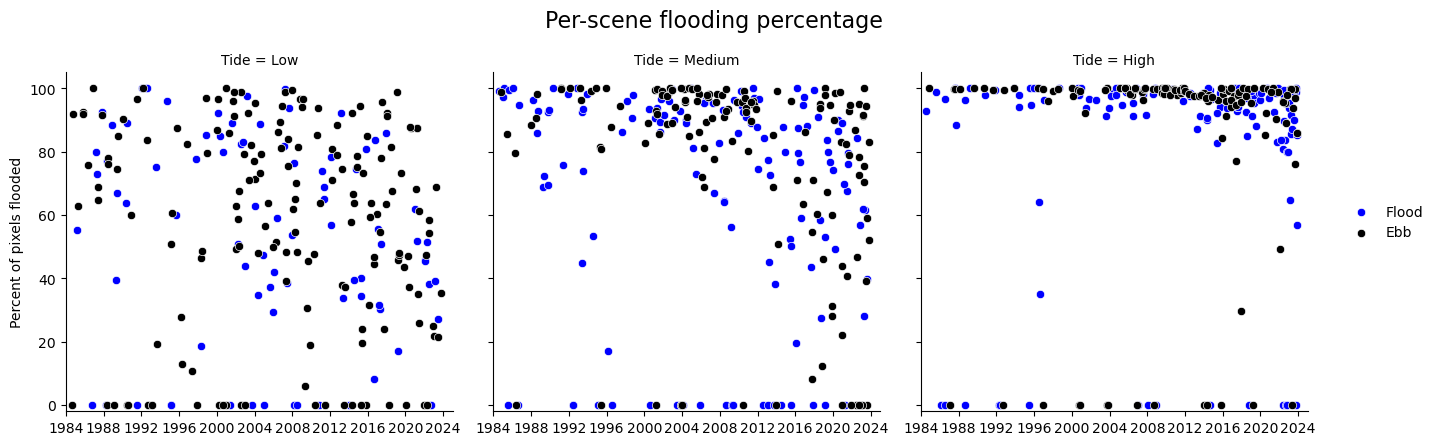

In [50]:
import seaborn as sns

# Create a facet grid for 'Verified (m)' categories

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.331, 0.698, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[df_x['Tide stage'] == 'Flood']

g = sns.FacetGrid(df_x, col="Tide", hue = 'Tide stage', col_wrap=3, height=4.5, palette={'Ebb': 'black', 'Flood': 'blue'}) 
# g = sns.FacetGrid(df_y, col="Tide", col_wrap=3, height=4) 
g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# Set axis labels and adjust layout
g.set_axis_labels("", "Percent of pixels flooded")
plt.suptitle('Per-scene flooding percentage', fontsize=16)

g.add_legend(title='')

g.set(ylim=(-2, 105))  # Set the y-axis limits
g.set(xlim=(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31')))
g.tight_layout()

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# g.savefig('cerf_variablethresholds.png', bbox_inches='tight', dpi = 300)

plt.show()

In [31]:
Map.addLayer(bbva)

Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [73]:
#NOW PIE

path = r'C:/Users/arj26323/Documents/Data/flats/MA tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_tides = pd.concat(li, axis=0, ignore_index=True)

df_tides

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m)
0,1985/01/01,00:00,2.366,-,2.385
1,1985/01/01,01:00,2.074,-,2.081
2,1985/01/01,02:00,1.663,-,1.636
3,1985/01/01,03:00,1.193,-,1.203
4,1985/01/01,04:00,0.754,-,0.74
...,...,...,...,...,...
350635,1984/12/31,19:00,0.986,-,1.047
350636,1984/12/31,20:00,1.408,-,1.453
350637,1984/12/31,21:00,1.902,-,1.919
350638,1984/12/31,22:00,2.317,-,2.34


In [74]:
df2 = df_tides.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

df_time = df2.copy()
df_time['Verified (m)'] = df_time['Verified (m)'].replace('-', float('nan')).astype('float')
df_time = df_time.dropna()
df_time['Tide change'] = df_time['Verified (m)'].diff()
df_time['Tide stage'] = df_time['Tide change'].apply(lambda x: 'Ebb' if x < 0 else 'Flood')

time_mask = (df_time['Time (GMT)'].dt.hour == 16)

df_time = df_time[time_mask]

df_time

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY,Tide change,Tide stage
16,1985/01/01,2024-03-07 16:00:00,1.013,-,1.224,1985-01-01,-0.509,Ebb
40,1985/01/02,2024-03-07 16:00:00,1.441,-,1.550,1985-01-02,-0.552,Ebb
64,1985/01/03,2024-03-07 16:00:00,1.891,-,1.876,1985-01-03,-0.479,Ebb
88,1985/01/04,2024-03-07 16:00:00,2.336,-,2.422,1985-01-04,-0.421,Ebb
112,1985/01/05,2024-03-07 16:00:00,2.745,-,3.071,1985-01-05,-0.384,Ebb
...,...,...,...,...,...,...,...,...
350536,1984/12/27,2024-03-07 16:00:00,1.312,-,1.249,1984-12-27,0.455,Flood
350560,1984/12/28,2024-03-07 16:00:00,0.898,-,0.968,1984-12-28,0.384,Flood
350584,1984/12/29,2024-03-07 16:00:00,0.619,-,0.761,1984-12-29,0.104,Flood
350608,1984/12/30,2024-03-07 16:00:00,0.522,-,0.608,1984-12-30,-0.214,Ebb


In [75]:
bbma = ee.Geometry.Polygon([[-70.8, 42.75], [-70.8, 42.8], [-70.86, 42.8], [-70.86, 42.75]])
Map.addLayer(bbma)

# Map

In [76]:
elevation = ee.Image('USGS/3DEP/10m').clip(bbva) ##This is 1/3 arc second, or 10 m.

In [77]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(bbma) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbma)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(bbma)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbma)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(bbma)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbma)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(bbma)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bbma)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [78]:
#Percentage of pixels in study area flagged WITH ELEVATION THRESHOLDS

def calculate_percentage(image):
    # Select the "flats" band
    flats_band = image.select('flats')
    
    # Load the elevation band from the image
    elevation_band = image.select('elevation')
    
    # Define the different thresholds based on elevation
    threshold_below_elevation = 0.2
    threshold_above_elevation = 0.8

    # Condition for masking based on elevation using expression()
    threshold_mask = flats_band.expression(
        "(elev >= 0.85) ? flats > threshold_above : flats > threshold_below",
        {
            'elev': image.select('elevation'), 
            'flats': flats_band,
            'threshold_above': threshold_above_elevation,
            'threshold_below': threshold_below_elevation
        }
    )

    # Calculate the total count of pixels within the area defined by flux_ga
    total_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bbma,
        scale=30
    ).get('flats')
      
    # Mask the image with the elevation-dependent threshold mask
    image2 = image.updateMask(threshold_mask)
    
    # Calculate the count of pixels above the threshold within the area defined by flux_ga
    above_threshold_count = image2.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=bbma,
        scale=30
    ).get('flats')
    
    # Calculate the percentage
    percentage = ee.Number(above_threshold_count).divide(total_pixel_count).multiply(100)
    
    return image.set('percentage_flood', percentage).set('total_pixel_count', total_pixel_count)


# Map the function over the image collection
perflood_l8 = l8_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l8.aggregate_array('system:time_start')
percentages = perflood_l8.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l8.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df8 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df8['Date'] = pd.to_datetime(df8['Date'], unit='ms')

# Sort the DataFrame by Date
df8 = df8.sort_values(by='Date')

In [79]:
# Landsat 5
perflood_l5 = l5_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l5.aggregate_array('system:time_start')
percentages = perflood_l5.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l5.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df5 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df5['Date'] = pd.to_datetime(df5['Date'], unit='ms')

# Sort the DataFrame by Date
df5 = df5.sort_values(by='Date')

In [80]:
# Landsat 7
perflood_l7 = l7_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l7.aggregate_array('system:time_start')
percentages = perflood_l7.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l7.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df7 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df7['Date'] = pd.to_datetime(df7['Date'], unit='ms')

# Sort the DataFrame by Date
df7 = df7.sort_values(by='Date')

In [81]:
#Landsat 9
perflood_l9 = l9_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l9.aggregate_array('system:time_start')
percentages = perflood_l9.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l9.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df9 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df9['Date'] = pd.to_datetime(df9['Date'], unit='ms')

# Sort the DataFrame by Date
df9 = df9.sort_values(by='Date')

In [82]:
df = pd.concat([df5,df7,df8,df9], axis=0)
df = df.reset_index(drop=True)

df['DOY'] = df['Date'].dt.strftime('%Y-%m-%d')
df['DOY'] = pd.to_datetime(df['DOY'])
df

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-05-02 14:53:53.577,26.433820,20958,1984-05-02
1,1984-06-03 14:54:48.557,15.236838,30295,1984-06-03
2,1984-06-19 14:55:05.058,2.090747,2248,1984-06-19
3,1984-09-23 14:56:49.967,16.345456,30302,1984-09-23
4,1984-10-25 14:56:44.357,0.000000,0,1984-10-25
...,...,...,...,...
710,2023-08-26 15:26:36.811,14.548815,30298,2023-08-26
711,2023-09-27 15:26:42.349,18.968882,9737,2023-09-27
712,2023-10-13 15:26:55.770,16.635866,30302,2023-10-13
713,2023-11-30 15:27:01.249,17.218170,30160,2023-11-30


In [83]:
df_all = df[df['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes


In [84]:
df_combined = pd.merge(df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']

In [85]:
df_ultra = df_combined[df_combined['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes, approx. half (CHECK PIX COUNT)
df_ultra

,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Tide change,Tide stage,Date
0,1984-05-02 14:53:53.577,26.433820,20958,1984-05-02,1984/05/02,2024-03-07 16:00:00,2.627,-,2.620,0.533,Flood,1984-05-02 14:53:53.577
1,1984-06-03 14:54:48.557,15.236838,30295,1984-06-03,1984/06/03,2024-03-07 16:00:00,1.516,-,1.642,0.726,Flood,1984-06-03 14:54:48.557
2,1984-06-19 14:55:05.058,2.090747,2248,1984-06-19,1984/06/19,2024-03-07 16:00:00,0.696,-,0.700,0.344,Flood,1984-06-19 14:55:05.058
3,1984-09-23 14:56:49.967,16.345456,30302,1984-09-23,1984/09/23,2024-03-07 16:00:00,2.467,-,2.355,-0.469,Ebb,1984-09-23 14:56:49.967
4,1984-10-25 14:56:44.357,0.000000,0,1984-10-25,1984/10/25,2024-03-07 16:00:00,3.642,-,3.577,0.390,Flood,1984-10-25 14:56:44.357
...,...,...,...,...,...,...,...,...,...,...,...,...
705,2023-07-25 15:26:18.246,15.721040,5076,2023-07-25,2023/07/25,2024-03-07 16:00:00,0.548,-,0.708,0.179,Flood,2023-07-25 15:26:18.246
706,2023-08-26 15:26:36.811,14.548815,30298,2023-08-26,2023/08/26,2024-03-07 16:00:00,0.739,-,0.928,-0.476,Ebb,2023-08-26 15:26:36.811
707,2023-09-27 15:26:42.349,18.968882,9737,2023-09-27,2023/09/27,2024-03-07 16:00:00,2.314,-,2.542,-0.502,Ebb,2023-09-27 15:26:42.349
708,2023-10-13 15:26:55.770,16.635866,30302,2023-10-13,2023/10/13,2024-03-07 16:00:00,2.852,-,3.125,-0.044,Ebb,2023-10-13 15:26:55.770


In [86]:
# import statsmodels.api as sm

# Add a constant term to the DataFrame for the intercept
df_x = df_ultra.copy()

df_x['Verified (m)'] = df_x['Verified (m)'].replace('-', float('nan')).astype('float')

df_x = df_x.dropna()

df_x['Date'] = pd.to_datetime(df_x['Date'])

df_x['intercept'] = 1

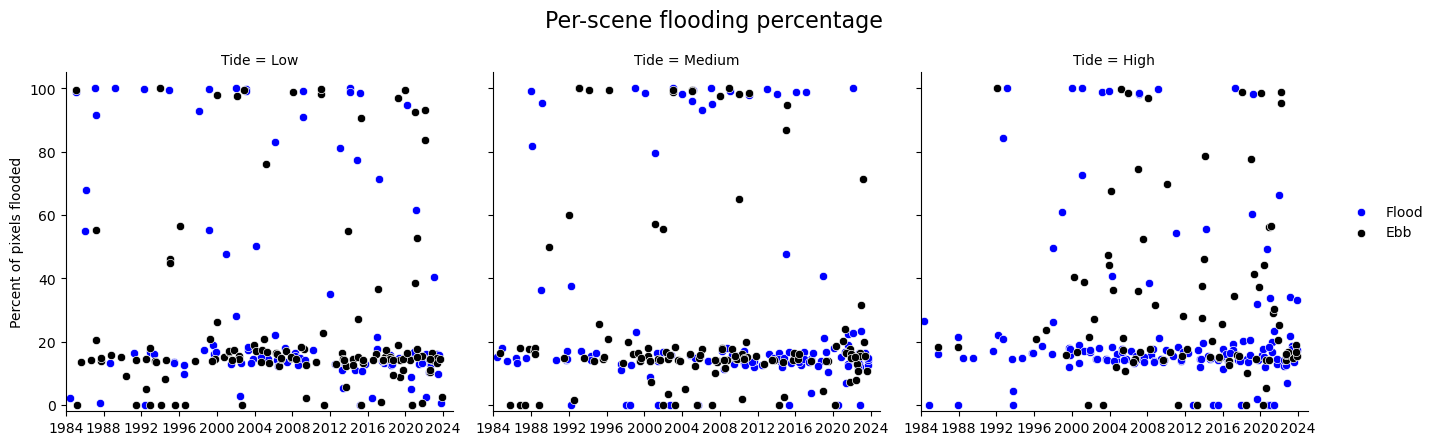

In [87]:
import seaborn as sns

# Create a facet grid for 'Verified (m)' categories

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-10, 1.17, 2.5, 30], labels = ['Low', 'Medium', 'High'])
df_y = df_x[df_x['Tide stage'] == 'Flood']

g = sns.FacetGrid(df_x, col="Tide", hue = 'Tide stage', col_wrap=3, height=4.5, palette={'Ebb': 'black', 'Flood': 'blue'}) 
# g = sns.FacetGrid(df_y, col="Tide", col_wrap=3, height=4) 
g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# Set axis labels and adjust layout
g.set_axis_labels("", "Percent of pixels flooded")
plt.suptitle('Per-scene flooding percentage', fontsize=16)

g.add_legend(title='')

g.set(ylim=(-2, 105))  # Set the y-axis limits
g.set(xlim=(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31')))
g.tight_layout()

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# g.savefig('cerf_variablethresholds.png', bbox_inches='tight', dpi = 300)

plt.show()